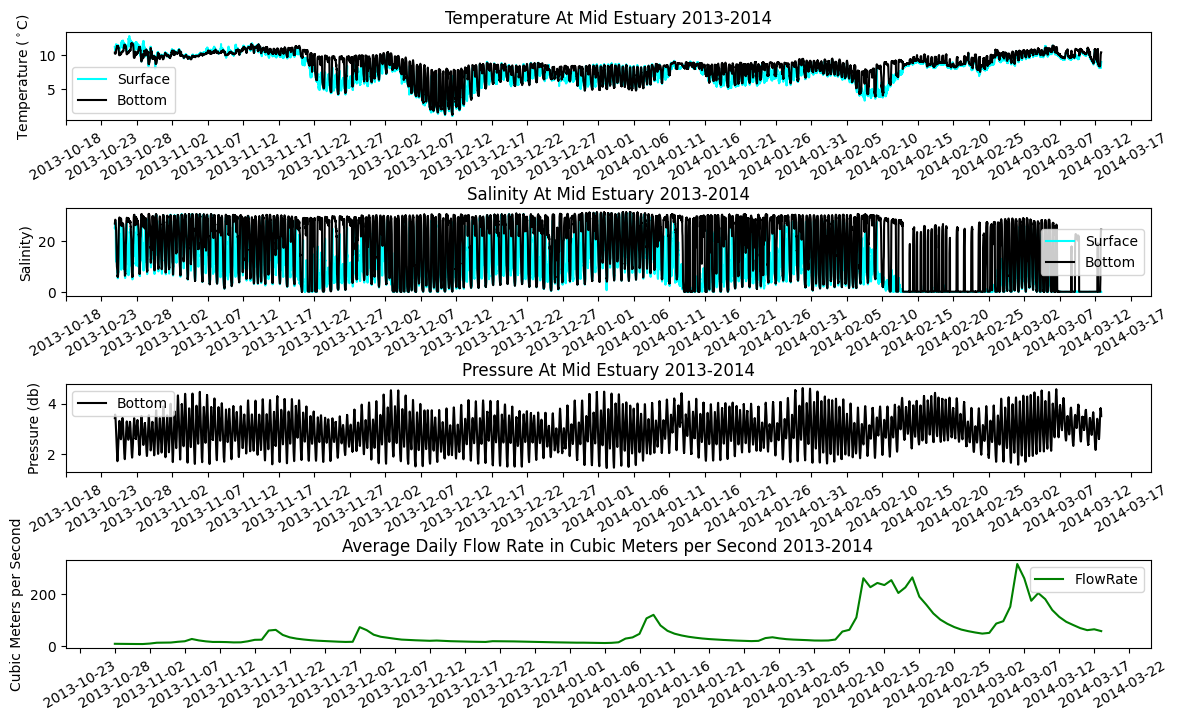

In [29]:
import pandas as pd
import scipy.io as sio
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

def Array_To_DataFrame(matDF, varName) :
    npArray = np.array([])
    for i in range (matDF[varName].shape[0]) :
        npArray = np.concatenate((npArray, matDF[varName][i].flatten()))
    return npArray
def matFile_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {dictKey:dictValue for dictKey, dictValue in tempDF.items() if dictKey[0] != '_'}
    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    return matMidDF


fileList = ['2013_14\\hobo_PrivateDock_2013_12_13.mat', '2013_14\\hobo_PrivateDock_2013_14_01.mat', '2013_14\\hobo_PrivateDock_2014_01_16.mat' , '2013_14\\hobo_PrivateDock_2014_03_12.mat']
#import downriver bottom data
matMidDF = matFile_To_DF(fileList[0])

for matFile in fileList[1: ] :
    matMidDF = pd.concat([matMidDF, matFile_To_DF(matFile)], ignore_index = True)

#mat lab date origin
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')

#set arrays 
matMidTimeArray = Array_To_DataFrame(matMidDF, 'DN')
matMidSurfaceSalinityArray = Array_To_DataFrame(matMidDF, 'SS')
matMidBottomSalinityArray = Array_To_DataFrame(matMidDF, 'SB')
matMidBottomPressureArray = Array_To_DataFrame(matMidDF, 'BP')
matMidBottomTemperatureArray = Array_To_DataFrame(matMidDF, 'TB')
matMidSurfaceTemperatureArray = Array_To_DataFrame(matMidDF, 'TS')
matMidFlatDF = pd.DataFrame({'DN' : matMidTimeArray.flatten(), 'SS' : matMidSurfaceSalinityArray.flatten(), 'SB' : matMidBottomSalinityArray.flatten(), 'BP' : matMidBottomPressureArray.flatten(), 'TB' : matMidBottomTemperatureArray.flatten(), 'TS' : matMidSurfaceTemperatureArray.flatten()})

matMidFlatDF = matMidFlatDF.sort_values(['DN'], ascending = [True])

tmsMidriver = matMidFlatDF['DN'] * np.timedelta64(1, 'D') + origin
#reading in flow data
flowDF = pd.read_csv('2013_2014alsea.csv')
flowDF['fRate'] = flowDF['max_va'] * 0.0283168
#create a new column for flow dates
for index, row in flowDF.iterrows():
    calcDate = pd.Timestamp(year=int(row['begin_yr']), month=int(row['month_nu']), day=int(row['day_nu']))
    flowDF.loc[index, 'DN'] = calcDate

tmsFlow = flowDF['DN']

#create the subplots
fig, (axtemp, axsal,axro, axflow) = plt.subplots(4,figsize=(14, 8))

#set the titles for the plots
axtemp.set_title("Temperature At Mid Estuary 2013-2014")
axsal.set_title("Salinity At Mid Estuary 2013-2014")
axro.set_title("Pressure At Mid Estuary 2013-2014")
axflow.set_title("Average Daily Flow Rate in Cubic Meters per Second 2013-2014")

#set up the y axis for each plot
plt.setp(axtemp, ylabel = "Temperature ($^\circ$C)")
plt.setp(axsal, ylabel = "Salinity)")
plt.setp(axro, ylabel = "Pressure (db)")
plt.setp(axflow, ylabel = "Cubic Meters per Second")

#plot the data on the proper plot

axtemp.plot(tmsMidriver, matMidFlatDF['TS'], color = 'cyan', label='Surface')
axtemp.plot(tmsMidriver, matMidFlatDF['TB'], color = 'black', label='Bottom')
axsal.plot(tmsMidriver,matMidFlatDF['SS'],color = 'cyan', label = "Surface")
axsal.plot(tmsMidriver,matMidFlatDF['SB'],color = 'black', label = "Bottom")
axro.plot(tmsMidriver, matMidFlatDF['BP'], color = 'black', label = "Bottom")
axflow.plot(tmsFlow,flowDF['fRate'], color = 'green', label = 'FlowRate')


# Change the tick interval
axtemp.xaxis.set_major_locator(mdates.DayLocator(interval=5)) 
axsal.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axro.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axflow.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Puts x-axis labels on an angle
axtemp.xaxis.set_tick_params(rotation = 30)  
axsal.xaxis.set_tick_params(rotation = 30)
axro.xaxis.set_tick_params(rotation = 30)
axflow.xaxis.set_tick_params(rotation = 30)

#adjust space between the plots
plt.subplots_adjust(hspace=1)

axtemp.legend() 
axsal.legend()
axro.legend()
axflow.legend()
plt.show()

